In [7]:
# Initialize Otter
import otter
grader = otter.Notebook("lab02.ipynb")

# Lab 2: SQL

In this lab, we are going to practice viewing, sorting, grouping, and merging tables with SQL. We will explore the money donated during the 2016 election using the [Federal Election Commission's public records](https://www.fec.gov/data/). You will be connecting to a `sqlite` database containing the data. The data we will be working with in this lab is quite small (16MB); however, it is a sample taken from a larger database that is more than a few GBs.


### Due Date

This assignment is due at **Thursday, February 4th** at 11:59 pm.

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

### Lab Walk-Through

In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

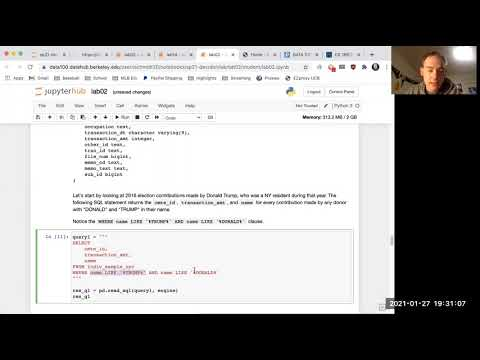

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo("bAP9dxCdyrc")

In [9]:
import pandas as pd
import sqlalchemy
from ds100_utils import fetch_and_cache
from pathlib import Path

### Connecting to SQLite

Download the database to local disk drive; this will take about a minute.

In [10]:
db_url = 'https://s3.amazonaws.com/berkeley-ds100/fec_nyc.sqlite'
db_filename = 'fec_nyc.db'
data_dir = Path('data')
fetch_and_cache(db_url, db_filename, data_dir = data_dir)
db_path = data_dir / db_filename

Downloading... Done!


The following cell will connect to the above database using the SQL Alchemy library. This library is more general than the `sqlite3` module from the standard library because it can connect to several different database management systems, such as MySQL and PostgreSQL. It also supports an advanced feature for generating queries called an [object relational mapper](https://docs.sqlalchemy.org/en/latest/orm/tutorial.html) or ORM, which we won't discuss in this course but is quite useful for application development.

In [11]:
engine = sqlalchemy.create_engine(f"sqlite:///{db_path}")
connection = engine.connect()

To check that everything is working we will list the available tables.

In [12]:
engine.table_names()

['cand', 'comm', 'indiv_sample_nyc']

## Table Descriptions

Here is a list of the tables in the database.  Each table links to the documentation on the [FEC page](https://www.fec.gov/data/browse-data/) for the dataset.

If you'd like, you can consult the FEC page for the descriptions of the tables to find out what the correspondence is.

- [`cand`](https://www.fec.gov/campaign-finance-data/candidate-summary-file-description/): Candidates table. Contains names and party affiliation.
- [`comm`](https://www.fec.gov/campaign-finance-data/committee-summary-file-description/): Committees table. Contains committee names and types.
- [`indiv_sample_nyc`](https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/): All individual contributions from New York City.

We can see the schemas of these tables with the following code.

In [13]:
for exp in connection.execute('SELECT sql FROM sqlite_master;'):
    print(exp[0])

CREATE TABLE "cand" (
    cand_id character varying(9),
    cand_name text,
    cand_pty_affiliation character varying(3),
    cand_election_yr integer,
    cand_office_st character varying(2),
    cand_office character(1),
    cand_office_district integer,
    cand_ici character(1),
    cand_status character(1),
    cand_pcc character varying(9),
    cand_st1 text,
    cand_st2 text,
    cand_city text,
    cand_st character varying(2),
    cand_zip character varying(10)
)
CREATE TABLE "comm"(
  "cmte_id" TEXT,
  "cmte_nm" TEXT,
  "tres_nm" TEXT,
  "cmte_st1" TEXT,
  "cmte_st2" TEXT,
  "cmte_city" TEXT,
  "cmte_st" TEXT,
  "cmte_zip" TEXT,
  "cmte_dsgn" TEXT,
  "cmte_tp" TEXT,
  "cmte_pty_affiliation" TEXT,
  "cmte_filing_freq" TEXT,
  "org_tp" TEXT,
  "connected_org_nm" TEXT,
  "cand_id" TEXT
)
CREATE TABLE indiv_sample_nyc (
    cmte_id character varying(9),
    amndt_ind character(1),
    rpt_tp character varying(3),
    transaction_pgi character(5),
    image_num bigint,
    trans

We can also look at the tables themselves.

The individual donations made by NY residents are shown below.

We use `LIMIT 5` to avoid loading a huge table. Although our tables shouldn't get too large to display, this is generally good practice when working in the notebook environment. Jupyter notebooks don't handle very large outputs well. Also note the `"""` to define our query. This allows us to have a query span multiple lines.

In [14]:
query = """
SELECT *
FROM indiv_sample_nyc
LIMIT 5
"""
pd.read_sql(query, engine)

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,C00445015,N,Q1,P,15951128130,15,IND,"SINGER, TRIPP MR.",NEW YORK,NY,...,"ATLANTIC MAILBOXES, INC.",OWNER,01302015,1000,,A-CF13736,1002485,,,4041420151241812398
1,C00510461,N,Q1,P,15951129284,15E,IND,"SIMON, DANIEL A",NEW YORK,NY,...,N/A,RETIRED,03292015,400,C00401224,VN8JBDDJBA8,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813640
2,C00422410,N,Q1,P,15970352211,15,IND,"ABDUL RAUF, FEISAL",NEW YORK,NY,...,THE CORDOBA INITIATIVE,CHAIRMAN,03042015,250,,VN8A3DBSYG6,1003643,,,4041620151241914560
3,C00510461,N,Q1,P,15951129280,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,...,METRO HYDRAULIC JACK CO,SALES,01162015,100,,VN8JBDAP4C4,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813630
4,C00510461,N,Q1,P,15951129281,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,...,METRO HYDRAULIC JACK CO,SALES,02162015,100,,VN8JBDBRDG3,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813632


Similarly, the database of candidates is given below.

In [15]:
query = """
SELECT *
FROM cand
LIMIT 5
"""
pd.read_sql(query, engine)

,cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip
0,H0AK00097,"COX, JOHN R.",REP,2014,AK,H,0,C,N,C00525261,P.O. BOX 1092,,ANCHOR POINT,AK,99556
1,H0AL02087,"ROBY, MARTHA",REP,2016,AL,H,2,I,C,C00462143,PO BOX 195,,MONTGOMERY,AL,36101
2,H0AL02095,"JOHN, ROBERT E JR",IND,2016,AL,H,2,C,N,,1465 W OVERBROOK RD,,MILLBROOK,AL,36054
3,H0AL05049,"CRAMER, ROBERT E ""BUD"" JR",DEM,2008,AL,H,5,,P,C00239038,PO BOX 2621,,HUNTSVILLE,AL,35804
4,H0AL05163,"BROOKS, MO",REP,2016,AL,H,5,I,C,C00464149,7610 FOXFIRE DRIVE,,HUNTSVILLE,AL,35802


And finally, the table of committees is given below.

In [16]:
query = """
SELECT *
FROM comm
LIMIT 5
"""
pd.read_sql(query, engine)

,cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
0,C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,,
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,,M,M,AMERICAN MEDICAL ASSOCIATION,
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,,OKLAHOMA CITY,OK,73107,U,N,,Q,L,TEAMSTERS LOCAL UNION 886,
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,,TOPEKA,KS,66612,U,Q,UNK,Q,T,,
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",,INDIANAPOLIS,IN,46202,U,Q,,Q,M,,


In CS61A or CS88, we saw basic queries similar to what we see below, which gives only the id and name of candidates from the Democratic party.

In [17]:
query = """
SELECT cand_id, cand_name
FROM cand
WHERE cand_pty_affiliation = 'DEM'
LIMIT 5
"""
pd.read_sql(query,engine)

,cand_id,cand_name
0,H0AL05049,"CRAMER, ROBERT E ""BUD"" JR"
1,H0AL07086,"SEWELL, TERRYCINA ANDREA"
2,H0AL07094,"HILLIARD, EARL FREDERICK JR"
3,H0AR01091,"GREGORY, JAMES CHRISTOPHER"
4,H0AR01109,"CAUSEY, CHAD"


---
## Question 1

For this question we will use SQL to extract data out of the `indiv_sample_nyc` table. The schema for this table is given below.

In [10]:
for exp in connection.execute('SELECT sql FROM sqlite_master WHERE name="indiv_sample_nyc";'):
    print(exp[0])

Let's start by looking at 2016 election contributions made by Donald Trump, who was a NY resident during that year. The following SQL statement returns the `cmte_id`, `transaction_amt`, and `name` for every contribution made by any donor with "DONALD" and "TRUMP" in their name.

Notice the `WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%'` clause.

In [19]:
query1 = """
SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%'
"""

res_q1 = pd.read_sql(query1, engine)
res_q1

,cmte_id,transaction_amt,name
0,C00230482,2600,"DONALD, TRUMP"
1,C00230482,2600,"DONALD, TRUMP"
2,C00014498,9000,"TRUMP, DONALD"
3,C00494229,2000,"TRUMP, DONALD MR"
4,C00571869,2700,"TRUMP, DONALD J."
...,...,...,...
152,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
153,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
154,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
155,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC


### Question 1a

If we look at the list above, it appears that some donations were not by Donald Trump himself, but instead by an entity called "DONALD J TRUMP FOR PRESIDENT INC". Fortunately, we see that our query only seems to have picked up one such anomalous name.

In [20]:
res_q1['name'].value_counts()

TRUMP, DONALD J.                    133
DONALD J TRUMP FOR PRESIDENT INC     15
TRUMP, DONALD                         4
DONALD, TRUMP                         2
TRUMP, DONALD J MR.                   1
TRUMP, DONALD MR                      1
TRUMP, DONALD J MR                    1
Name: name, dtype: int64

Revise the above query so that the 15 donations made by "DONALD J TRUMP FOR PRESIDENT INC" do not appear. Your resulting table should have 142 rows. 

Hint: Copy the above query into the cell below as a starting point!

Hint: Consider using `NOT LIKE`.

<!--
BEGIN QUESTION
name: q1a
-->

In [22]:
query_q1a = """
SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%'
AND name NOT LIKE '%DONALD J TRUMP FOR PRESIDENT INC%'
"""


res_q1a = pd.read_sql(query_q1a, engine)
res_q1a

,cmte_id,transaction_amt,name
0,C00230482,2600,"DONALD, TRUMP"
1,C00230482,2600,"DONALD, TRUMP"
2,C00014498,9000,"TRUMP, DONALD"
3,C00494229,2000,"TRUMP, DONALD MR"
4,C00571869,2700,"TRUMP, DONALD J."
...,...,...,...
137,C00580100,9752,"TRUMP, DONALD J."
138,C00580100,2574,"TRUMP, DONALD J."
139,C00580100,23775,"TRUMP, DONALD J."
140,C00580100,2000000,"TRUMP, DONALD J."


In [23]:
grader.check("q1a")

q1a passed!

### Question 1b

As a review of some of the key ideas from CS61A/CS88, let's refine our query above.

We see that many of the contributions above were to the same committee. Create a new SQL query that returns the total amount that Donald Trump contributed to each committee. Your table should have four columns: `cmte_id`, `total_amount`, `num_donations`, and `cmte_nm`. The `total_amount` is the total amount contributed to that committee, `num_donations` is the total number of donations, and `cmte_nm` is the name of the committee. Note that `cmte_nm` is not available in `indiv_sample_nyc`, so you will have to somehow obtain information from the `comm` table.

Your final table should be sorted in decreased order of `total_amount`.

**Note**: This is a hard question! Don't be afraid to reference the walkthrough video if you're stuck.

Hint: Use `GROUP BY` as covered in CS61A and CS88.

Hint: Use `COUNT(*)` as covered in CS61A and CS88.

Hint: Use `SUM()` as covered in CS61A and CS88.

Hint: Use `ORDER BY` as covered in CS61A and CS88.

Hint: Use `DESC` as covered in CS61A and CS88.

Hint: Your `WHERE` clause should be the same as question 1a.

Hint: You'll probably need either a join, or a subquery.

<!--
BEGIN QUESTION
name: q1b
-->

In [25]:
query_q1b = """
SELECT
    comm.cmte_id,
    SUM(transaction_amt) AS total_amount,
    COUNT(*) AS num_donations,
    cmte_nm
FROM indiv_sample_nyc, comm
WHERE comm.cmte_id = indiv_sample_nyc.cmte_id
AND name LIKE '%TRUMP%' AND name LIKE '%DONALD%'
AND name NOT LIKE '%DONALD J TRUMP FOR PRESIDENT INC%'
GROUP BY comm.cmte_id
ORDER BY total_amount DESC
"""


res_q1b = pd.read_sql(query_q1b, engine)
res_q1b

,cmte_id,total_amount,num_donations,cmte_nm
0,C00580100,18633157,131,"DONALD J. TRUMP FOR PRESIDENT, INC."
1,C00055582,10000,1,NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE
2,C00014498,9000,1,REPUBLICAN PARTY OF IOWA
3,C00571869,5400,2,DONOVAN FOR CONGRESS
4,C00230482,5200,2,GRASSLEY COMMITTEE INC
5,C00136457,5000,1,NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE
6,C00034033,5000,1,SOUTH CAROLINA REPUBLICAN PARTY
7,C00554949,2600,1,FRIENDS OF DAVE BRAT INC.
8,C00494229,2000,1,HELLER FOR SENATE
9,C00369033,1000,1,TEXANS FOR SENATOR JOHN CORNYN INC


In [26]:
grader.check("q1b")

q1b passed!

## Question 2

### Question 2a

When you printed the schema for the tables, you may have noticed that both the `cand` and `comm` tables have a `cand_id` column. Let's try joining these two tables on this column.

List the first 5 candidate names (`cand_name`) in reverse lexicographic order by `cand_name`, along with their corresponding committee names. Only select rows that have a matching `cand_id` in both tables.

Your output should look similar to:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>cand_name</th>
      <th>cmte_nm</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>ZUTLER, DANIEL PAUL MR</td>
      <td>CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ZUMWALT, JAMES</td>
      <td>ZUMWALT FOR CONGRESS</td>
    </tr>
    <tr>
      <th>2</th>
      <td>ZUKOWSKI, ANDREW GEORGE</td>
      <td>ZUKOWSKI FOR CONGRESS</td>
    </tr>
    <tr>
      <th>3</th>
      <td>ZUCCOLO, JOE</td>
      <td>JOE ZUCCOLO FOR CONGRESS</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ZORN, ROBERT ERWIN</td>
      <td>CONSTITUTIONAL COMMITTEE</td>
    </tr>
  </tbody>
</table>

<!--
BEGIN QUESTION
name: q2a
-->

In [27]:
query_q2a = """
SELECT cand_name, cmte_nm
FROM cand c1 INNER JOIN comm c2 ON c1.cand_id = c2.cand_id
ORDER BY cand_name DESC
LIMIT 5
"""


res_q2a = pd.read_sql(query_q2a, engine)
res_q2a

,cand_name,cmte_nm
0,"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
1,"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
2,"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
3,"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
4,"ZORN, ROBERT ERWIN",CONSTITUTIONAL COMMITTEE


In [28]:
grader.check("q2a")

q2a passed!

### Question 2b

As in the previous part, list the first 5 candidate names (`cand_name`) by reverse lexicographic order and their corresponding committee names (`cmte_nm`). This time, include all candidate names. If there is no matching `cand_id` in the `comm` table, then `cmte_nm` should be NULL (or `None` in the Python representation).

Your output should look similar to:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>cand_name</th>
      <th>cmte_nm</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>ZUTLER, DANIEL PAUL MR</td>
      <td>CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ZUMWALT, JAMES</td>
      <td>ZUMWALT FOR CONGRESS</td>
    </tr>
    <tr>
      <th>2</th>
      <td>ZUKOWSKI, ANDREW GEORGE</td>
      <td>ZUKOWSKI FOR CONGRESS</td>
    </tr>
    <tr>
      <th>3</th>
      <td>ZUCCOLO, JOE</td>
      <td>JOE ZUCCOLO FOR CONGRESS</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ZORNOW, TODD MR</td>
      <td>None</td>
    </tr>
  </tbody>
</table>

<!--
BEGIN QUESTION
name: q2b
-->

In [29]:
query_q2b = """
SELECT cand_name, cmte_nm
FROM cand c1 LEFT JOIN comm c2 ON c1.cand_id = c2.cand_id
ORDER BY cand_name DESC
LIMIT 5
"""


res_q2b = pd.read_sql(query_q2b, engine)
res_q2b

,cand_name,cmte_nm
0,"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
1,"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
2,"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
3,"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
4,"ZORNOW, TODD MR",None


In [30]:
grader.check("q2b")

q2b passed!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [31]:
grader.check_all()

q1a passed!

q1b passed!

q2a passed!

q2b passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)